In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from datetime import datetime
import warnings

In [50]:
# Load your CSV file
df = pd.read_csv('data1.csv')  # Replace with your actual file path

# Check the data first
print("Data shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

# Simple date creation (your months are already numeric)
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))

# Create trade balance column
df['Trade_Balance'] = df.apply(
    lambda row: row['Value_USD_Million'] if row['Trade_Type'] == 'Export' 
    else -row['Value_USD_Million'], axis=1
)

print("\n✓ Data preparation complete!")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")


Data shape: (390, 14)

Column names:
['Year', 'Month', 'Trade_Type', 'Partner_Country', 'Partner_Region', 'Commodity_Category', 'Commodity_Subcategory', 'Value_USD_Million', 'Value_KES_Billion', 'Volume_Metric_Tons', 'Growth_Rate_YoY', 'Quarter', 'COVID_Period', 'Economic_Event']

First few rows:
   Year  Month Trade_Type Partner_Country Partner_Region  \
0  2020      1     Export          Uganda    East Africa   
1  2020      1     Export     Netherlands         Europe   
2  2020      1     Export  United Kingdom         Europe   
3  2020      1     Import           China           Asia   
4  2020      1     Import           India           Asia   

      Commodity_Category Commodity_Subcategory  Value_USD_Million  \
0  Agricultural Products                   Tea               89.2   
1  Agricultural Products           Cut Flowers               85.6   
2  Agricultural Products                Coffee               45.3   
3     Manufactured Goods             Machinery              245.8

### 1. TRADE BALANCE TREND

In [51]:
# Monthly trade data
monthly_trade = df.groupby(['Date', 'Trade_Type'])['Value_USD_Million'].sum().reset_index()
trade_pivot = monthly_trade.pivot(index='Date', columns='Trade_Type', values='Value_USD_Million').fillna(0)
trade_pivot['Trade_Balance'] = trade_pivot['Export'] - trade_pivot['Import']
trade_pivot = trade_pivot.reset_index()

# Interactive plot
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=trade_pivot['Date'], y=trade_pivot['Export'],
               mode='lines', name='Exports', 
               line=dict(color='green', width=4, shape='spline', smoothing=1.3)),
    secondary_y=False
)

fig.add_trace(
    go.Scatter(x=trade_pivot['Date'], y=trade_pivot['Import'],
               mode='lines', name='Imports', 
               line=dict(color='red', width=4, shape='spline', smoothing=1.3)),
    secondary_y=False
)

fig.add_trace(
    go.Scatter(x=trade_pivot['Date'], y=trade_pivot['Trade_Balance'],
               mode='lines', name='Trade Balance', 
               line=dict(color='blue', width=3, dash='dash', shape='spline', smoothing=1.3)),
    secondary_y=True
)

fig.add_hline(y=0, line_dash="dot", line_color="black", secondary_y=True)
fig.update_layout(title='Kenya Monthly Trade Balance Trend', height=600)
fig.update_yaxes(title_text="Trade Value (USD Millions)", secondary_y=False)
fig.update_yaxes(title_text="Trade Balance (USD Millions)", secondary_y=True)
fig.show()

In [52]:
def create_trade_balance_trend(df):
    """Interactive monthly trade balance trend"""
    # Aggregate by month and trade type
    monthly_trade = df.groupby(['Date', 'Trade_Type'])['Value_USD_Million'].sum().reset_index()
    
    # Pivot for easier plotting
    trade_pivot = monthly_trade.pivot(index='Date', columns='Trade_Type', values='Value_USD_Million').fillna(0)
    trade_pivot['Trade_Balance'] = trade_pivot['Export'] - trade_pivot['Import']
    trade_pivot = trade_pivot.reset_index()
    
    # Create interactive plot
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    # Add export line
    fig.add_trace(
        go.Scatter(x=trade_pivot['Date'], y=trade_pivot['Export'],
                   mode='lines+markers', name='Exports',
                   line=dict(color='green', width=3),
                   hovertemplate='Date: %{x}<br>Exports: $%{y:.1f}M<extra></extra>'),
        secondary_y=False,
    )
    
    # Add import line
    fig.add_trace(
        go.Scatter(x=trade_pivot['Date'], y=trade_pivot['Import'],
                   mode='lines+markers', name='Imports',
                   line=dict(color='red', width=3),
                   hovertemplate='Date: %{x}<br>Imports: $%{y:.1f}M<extra></extra>'),
        secondary_y=False,
    )
    
    # Add trade balance
    fig.add_trace(
        go.Scatter(x=trade_pivot['Date'], y=trade_pivot['Trade_Balance'],
                   mode='lines+markers', name='Trade Balance',
                   line=dict(color='blue', width=2, dash='dash'),
                   hovertemplate='Date: %{x}<br>Balance: $%{y:.1f}M<extra></extra>'),
        secondary_y=True,
    )
    
    # Add zero line
    fig.add_hline(y=0, line_dash="dot", line_color="black", secondary_y=True)
    
    fig.update_layout(
        title='Kenya Monthly Trade Balance Trend (2020-2024)',
        xaxis_title='Date',
        hovermode='x unified',
        height=600
    )
    
    fig.update_yaxes(title_text="Trade Value (USD Millions)", secondary_y=False)
    fig.update_yaxes(title_text="Trade Balance (USD Millions)", secondary_y=True)
    
    return fig

fig = create_trade_balance_trend(df)
fig.show()

### 2. COVID IMPACT ANALYSIS

In [53]:

covid_data = df.groupby(['COVID_Period', 'Trade_Type'])['Value_USD_Million'].sum().reset_index()
fig = px.bar(
    covid_data, 
    x='COVID_Period', 
    y='Value_USD_Million',
    color='Trade_Type',
    barmode='group',
    title='Trade Impact Across COVID-19 Periods',
    height=500)
fig.update_layout(xaxis_tickangle=-45)
fig.show()

### 3. TOP TRADING PARTNERS

In [34]:
# Top 15 trading partners
partner_totals = df.groupby('Partner_Country')['Value_USD_Million'].sum().sort_values(ascending=False).head(15).reset_index()
partner_totals['Cumulative_Percent'] = partner_totals['Value_USD_Million'].cumsum() / partner_totals['Value_USD_Million'].sum() * 100

# Pareto chart
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Bar(x=partner_totals['Partner_Country'], y=partner_totals['Value_USD_Million'],
                    name='Trade Value', marker_color='lightblue'), secondary_y=False)
fig.add_trace(go.Scatter(x=partner_totals['Partner_Country'], y=partner_totals['Cumulative_Percent'],
                        mode='lines+markers', name='Cumulative %', line=dict(color='red', width=2)), secondary_y=True)
fig.add_hline(y=80, line_dash="dash", line_color="orange", secondary_y=True)
fig.update_layout(title='Trading Partner Concentration (Pareto Chart)', height=600)
fig.update_yaxes(title_text="Trade Value (USD Millions)", secondary_y=False)
fig.update_yaxes(title_text="Cumulative Percentage (%)", secondary_y=True)
fig.update_xaxes(tickangle=-45)
fig.show()

### 4. TREEMAP OF TRADING PARTNERS

In [35]:
partner_data = df.groupby(['Partner_Country', 'Partner_Region', 'Trade_Type'])['Value_USD_Million'].sum().reset_index()
fig = px.treemap(partner_data, path=['Partner_Region', 'Partner_Country', 'Trade_Type'],
                values='Value_USD_Million', title='Trading Partners by Region', height=700)
fig.show()

### 5. IMPORT VS EXPORT DEPENDENCY BUBBLE CHART

In [36]:
partner_trade = df.pivot_table(index='Partner_Country', columns='Trade_Type', 
                              values='Value_USD_Million', aggfunc='sum', fill_value=0).reset_index()
partner_trade['Total_Trade'] = partner_trade['Export'] + partner_trade['Import']
region_map = df[['Partner_Country', 'Partner_Region']].drop_duplicates()
partner_trade = partner_trade.merge(region_map, on='Partner_Country', how='left')

fig = px.scatter(partner_trade, x='Import', y='Export', size='Total_Trade', color='Partner_Region',
                hover_name='Partner_Country', title='Import vs Export Dependency by Partner', height=600)
# Add balanced trade line
max_val = max(partner_trade['Import'].max(), partner_trade['Export'].max())
fig.add_trace(go.Scatter(x=[0, max_val], y=[0, max_val], mode='lines', name='Balanced Trade Line',
                        line=dict(dash='dash', color='gray')))
fig.show()


### 6. COMMODITY BUTTERFLY CHART

In [37]:
commodity_data = df.groupby(['Commodity_Category', 'Trade_Type'])['Value_USD_Million'].sum().reset_index()
commodity_pivot = commodity_data.pivot(index='Commodity_Category', columns='Trade_Type', values='Value_USD_Million').fillna(0)
commodity_pivot['Import'] = -commodity_pivot['Import']  # Make imports negative
commodity_pivot = commodity_pivot.reset_index()

fig = go.Figure()
fig.add_trace(go.Bar(y=commodity_pivot['Commodity_Category'], x=commodity_pivot['Export'],
                    orientation='h', name='Exports', marker_color='green'))
fig.add_trace(go.Bar(y=commodity_pivot['Commodity_Category'], x=commodity_pivot['Import'],
                    orientation='h', name='Imports', marker_color='red'))
fig.update_layout(title='Exports vs Imports by Commodity (Butterfly Chart)', 
                 xaxis_title='Trade Value (USD Millions)', barmode='relative', height=600)
fig.add_vline(x=0, line_dash="dash", line_color="black")
fig.show()

### 7. SEASONAL PATTERNS (POLAR PLOT)

In [38]:
seasonal_data = df.groupby(['Month', 'Trade_Type'])['Value_USD_Million'].mean().reset_index()
fig = px.line_polar(seasonal_data, r='Value_USD_Million', theta='Month', color='Trade_Type', 
                   line_close=True, title='Seasonal Trading Patterns', height=600)
fig.show()


### 8. MONTHLY HEATMAP

In [39]:
monthly_data = df.pivot_table(index='Month', columns='Year', values='Value_USD_Million', aggfunc='sum')
fig = px.imshow(monthly_data, title="Monthly Trade Value Heatmap", 
               color_continuous_scale='Viridis', height=500)
fig.show()

### 9. REGIONAL COMPARISON

In [40]:
regional_data = df.groupby(['Partner_Region', 'Trade_Type'])['Value_USD_Million'].sum().reset_index()
fig = px.bar(regional_data, x='Partner_Region', y='Value_USD_Million', color='Trade_Type',
            barmode='group', title='Trade by Region - Exports vs Imports', height=500)
fig.update_layout(xaxis_tickangle=-45)
fig.show()

### 10. GROWTH RATE DISTRIBUTION

In [41]:
fig = px.violin(df, y='Growth_Rate_YoY', x='Trade_Type', color='COVID_Period', 
               box=True, title='Growth Rate Distribution by Trade Type', height=500)
fig.show()

### 11. STATIC MATPLOTLIB CHARTS

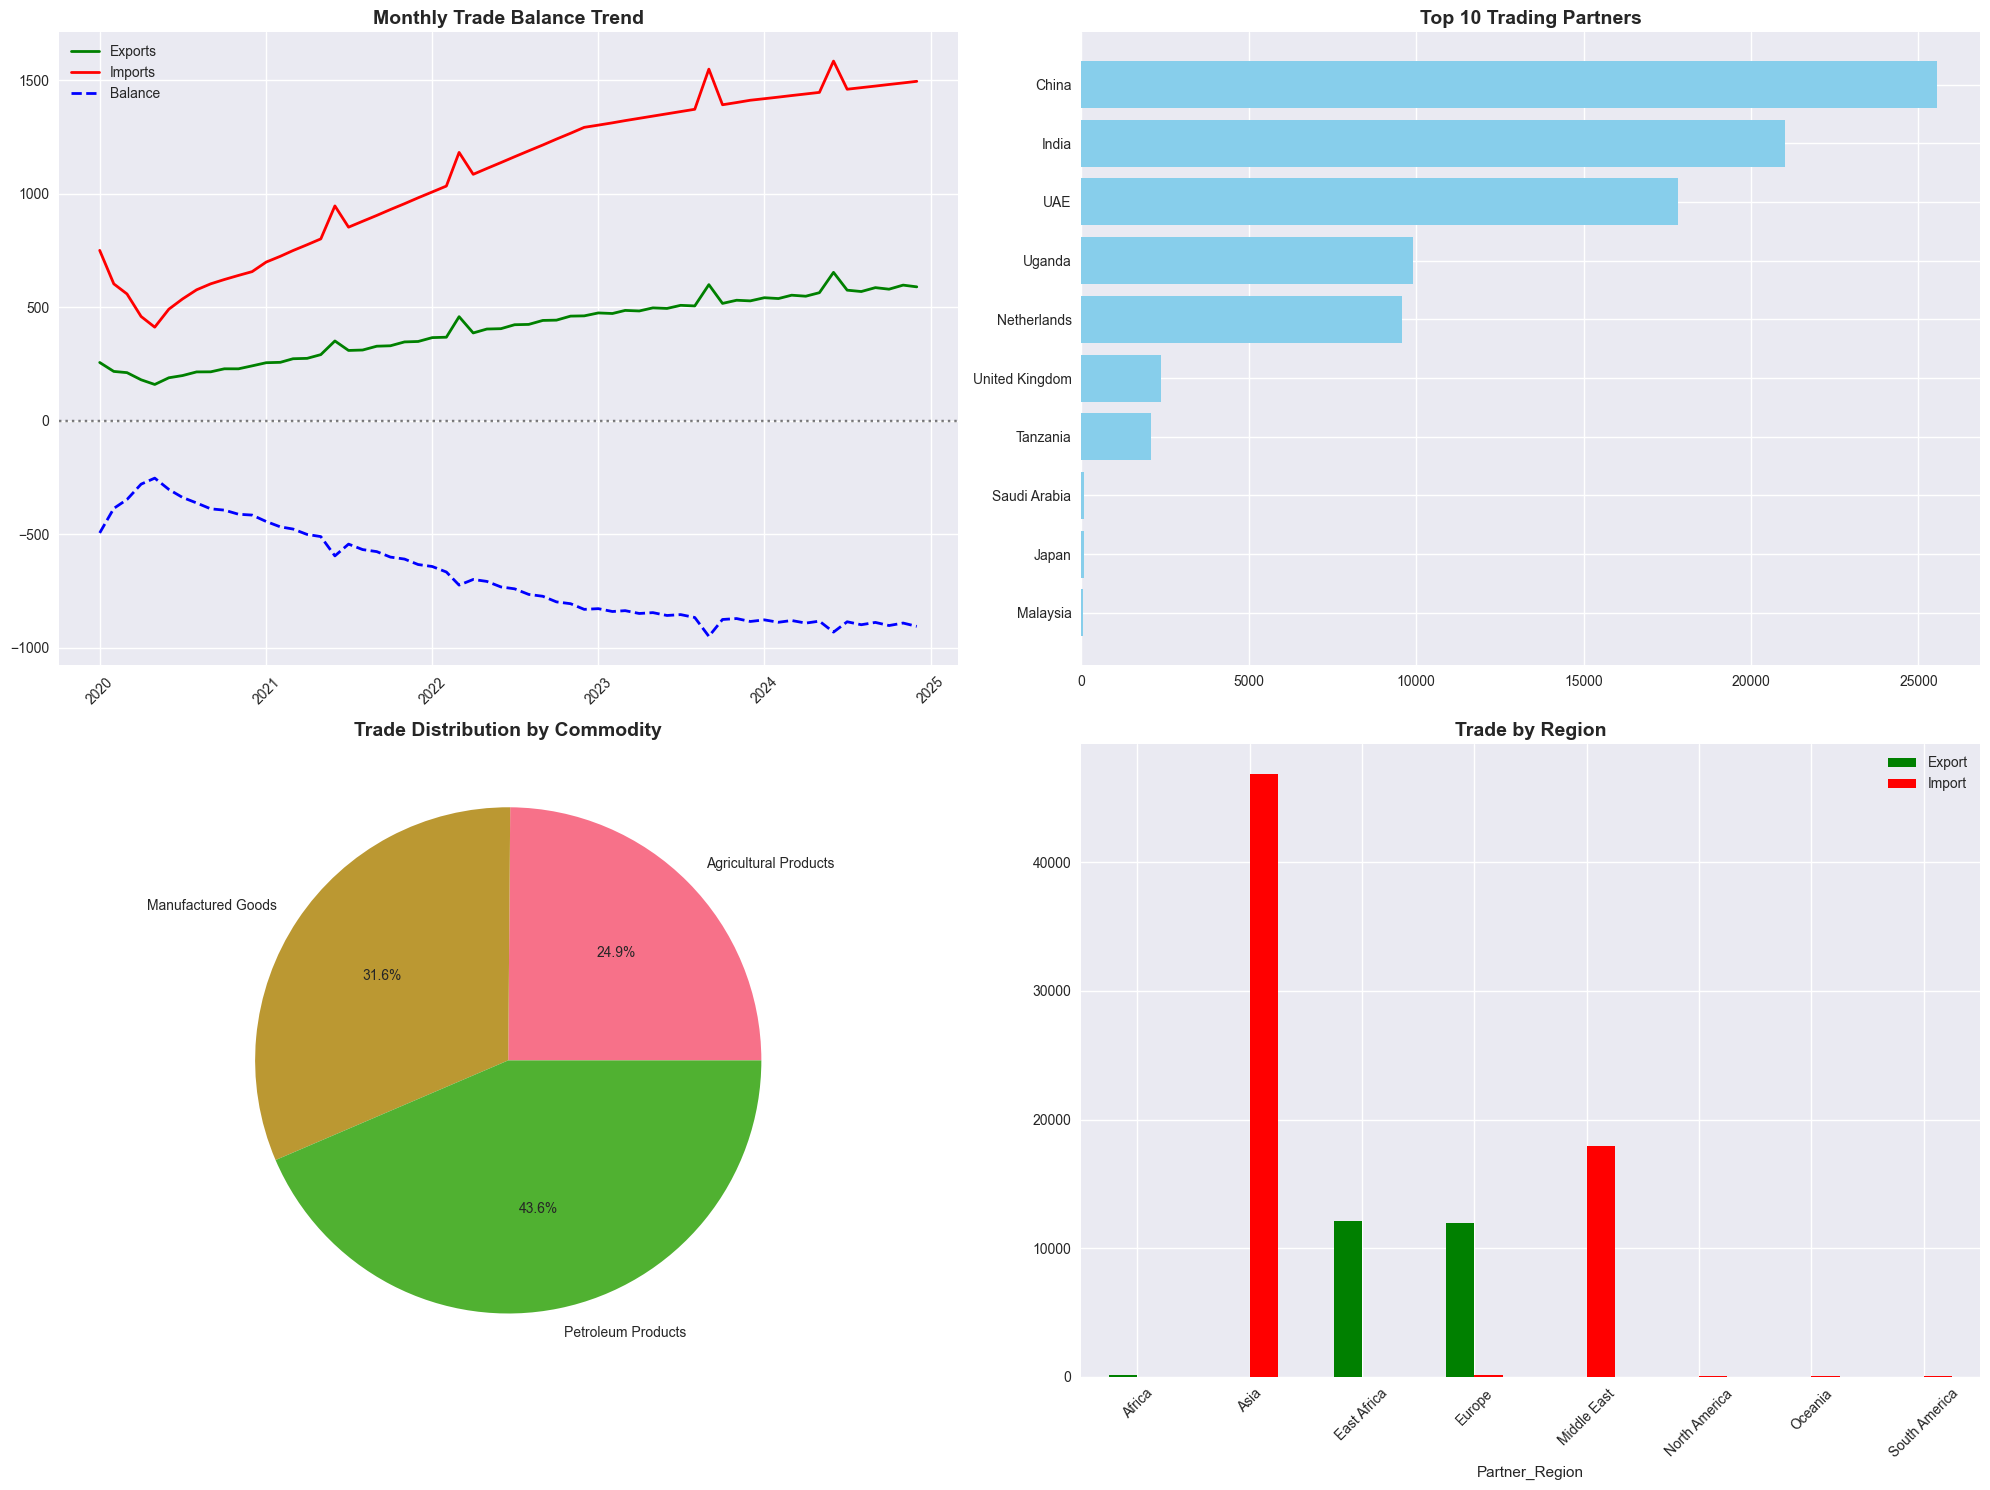

In [42]:
# Create a 2x2 subplot for static charts
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# 1. Trade balance timeline
monthly_trade_static = df.groupby(['Date', 'Trade_Type'])['Value_USD_Million'].sum().unstack()
monthly_trade_static['Balance'] = monthly_trade_static['Export'] - monthly_trade_static['Import']

axes[0,0].plot(monthly_trade_static.index, monthly_trade_static['Export'], label='Exports', linewidth=2, color='green')
axes[0,0].plot(monthly_trade_static.index, monthly_trade_static['Import'], label='Imports', linewidth=2, color='red')
axes[0,0].plot(monthly_trade_static.index, monthly_trade_static['Balance'], label='Balance', linewidth=2, color='blue', linestyle='--')
axes[0,0].axhline(y=0, color='black', linestyle=':', alpha=0.5)
axes[0,0].set_title('Monthly Trade Balance Trend', fontsize=14, fontweight='bold')
axes[0,0].legend()
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Top trading partners
top_partners = df.groupby('Partner_Country')['Value_USD_Million'].sum().sort_values(ascending=True).tail(10)
axes[0,1].barh(range(len(top_partners)), top_partners.values, color='skyblue')
axes[0,1].set_yticks(range(len(top_partners)))
axes[0,1].set_yticklabels(top_partners.index)
axes[0,1].set_title('Top 10 Trading Partners', fontsize=14, fontweight='bold')

# 3. Commodity pie chart
commodity_trade = df.groupby('Commodity_Category')['Value_USD_Million'].sum()
axes[1,0].pie(commodity_trade.values, labels=commodity_trade.index, autopct='%1.1f%%')
axes[1,0].set_title('Trade Distribution by Commodity', fontsize=14, fontweight='bold')

# 4. Regional bar chart
regional_static = df.groupby(['Partner_Region', 'Trade_Type'])['Value_USD_Million'].sum().unstack()
regional_static.plot(kind='bar', ax=axes[1,1], color=['green', 'red'])
axes[1,1].set_title('Trade by Region', fontsize=14, fontweight='bold')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].legend(['Export', 'Import'])

plt.tight_layout()
plt.show()

### 12. SUMMARY STATISTICS

In [43]:

print("\n" + "="*50)
print("KENYA TRADE ANALYSIS SUMMARY")
print("="*50)

total_trade = df['Value_USD_Million'].sum()
total_exports = df[df['Trade_Type'] == 'Export']['Value_USD_Million'].sum()
total_imports = df[df['Trade_Type'] == 'Import']['Value_USD_Million'].sum()
trade_balance = total_exports - total_imports

print(f"Total Trade Value: ${total_trade:,.1f} Million")
print(f"Total Exports: ${total_exports:,.1f} Million")
print(f"Total Imports: ${total_imports:,.1f} Million")
print(f"Trade Balance: ${trade_balance:,.1f} Million")
print(f"Number of Trading Partners: {df['Partner_Country'].nunique()}")
print(f"Number of Commodity Categories: {df['Commodity_Category'].nunique()}")

top_export_partner = df[df['Trade_Type'] == 'Export'].groupby('Partner_Country')['Value_USD_Million'].sum().idxmax()
top_import_partner = df[df['Trade_Type'] == 'Import'].groupby('Partner_Country')['Value_USD_Million'].sum().idxmax()

print(f"Top Export Partner: {top_export_partner}")
print(f"Top Import Partner: {top_import_partner}")

print("="*50)
print("Analysis Complete! All charts have been generated.")
print("="*50)


KENYA TRADE ANALYSIS SUMMARY
Total Trade Value: $89,391.6 Million
Total Exports: $24,283.2 Million
Total Imports: $65,108.4 Million
Trade Balance: $-40,825.2 Million
Number of Trading Partners: 36
Number of Commodity Categories: 3
Top Export Partner: Uganda
Top Import Partner: China
Analysis Complete! All charts have been generated.
